# Hubble Catalog of Variables Notebook (API version)
### 2019 - 2022, Rick White, Steve Lubow, Trenton McKinney

This notebook shows how to access the [Hubble Catalogs of Variables (HCV)][1]. The HCV is a large catalog of faint variable objects extracted from version 3 of the [Hubble Source Catalog][2]. The HCV project at the National Observatory of Athens was funded by the European Space Agency (PI: Alceste Bonanos). The data products for the HCV are available both at the [ESA Hubble Archive][3] at [ESAC][4] through the [HCV Explorer][5] interface and at STScI.

This notebook uses the [MAST HSC catalog interface][6], which supports queries to the current and previous versions of the [Hubble Source Catalog][2]. It allows searches of several different tables including the HCV summary and detailed tables. It also has an associated [API][7] that is used for data access in this notebook.

For similar examples using the [MAST CasJobs][8] interface, a SQL database query interface that is more complex to use, but more powerful than the API, see [HCV_CasJobs][9].


  [1]: http://archive.stsci.edu/hlsp/hcv/
  [2]: https://archive.stsci.edu/hst/hsc
  [3]: http://archives.esac.esa.int/ehst
  [4]: https://www.cosmos.esa.int/web/esdc
  [5]: http://archives.esac.esa.int/hcv-explorer
  [6]: https://catalogs.mast.stsci.edu/hsc
  [7]: https://catalogs.mast.stsci.edu/docs/hsc.html
  [8]: https://mastweb.stsci.edu/hcasjobs
  [9]: ../HCV_CASJOBS/HCV_casjobs_demo.ipynb

# Instructions
* Complete the initialization steps [described below](#initialization).
* Run the initialization steps before running the rest of the notebook.
* Modify and rerun any sections of the Table of Contents below.

# Table of Contents
* [Intialization](#initialization)
* [Variable objects in IC 1613](#ic1613)
    * [Name resolver](#resolver)
    * [Select objects from HCV](#summary)
    * [Information on HCV variable classification](#classification)
    * [Sky coverage](#positions)
    * [Properties of variable objects](#variability)
    * [Color magnitude diagram](#cmd)
* [Light curve for a nova in M87](#m87)
    * [Extract and plot light curve for the nova](#lightcurve)
    * [HLA cutout images for selected measurements](#cutouts)
* [Compare the HCV automatic classification to expert validations](#expert)
    * [Plot MAD variability index distribution](#mad_expert)
    * [Plot fraction of artifacts vs. MAD](#artifacts)
* [Plot light curve for most variable high-quality candidate in the HCV](#most_variable)

# Initialization <a name="initialization"></a>

### Install Python modules

1. _This notebook requires the use of **Python 3**._
1. Modules can be installed with `conda`, if using the [Anaconda distribution][1] of python, or with `pip`.
   - If you are using `conda`, do not install / update / remove a module with `pip`, that exists in a `conda` [channel][2].
   - If a module is not available with `conda`, then it's okay to install it with `pip`


  [1]: https://www.anaconda.com/products/distribution
  [2]: https://docs.conda.io/projects/conda/en/latest/user-guide/concepts/channels.html

In [1]:
import astropy
from astropy.coordinates import SkyCoord
import time
import sys
import os
import requests
import json
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO

from astropy.table import Table, join
from astropy.io import ascii

# set width for pprint
astropy.conf.max_width = 150

In [2]:
# set universal matplotlib parameters
plt.rcParams.update({'font.size': 16})

### MAST API functions

- Here we define several interrelated functions for retrieving information from the MAST API.
  - The `hcvcone(ra, dec, radius [, keywords])` function searches the HCV catalog near a position.
  - The `hcvsearch()` function performs general non-positional queries.
  - The `hcvmetadata()` function gives information about the columns available in a table. 

In [3]:
hscapiurl = "https://catalogs.mast.stsci.edu/api/v0.1/hsc"


def hcvcone(ra, dec, radius, table="hcvsummary", release="v3", format="csv", magtype="magaper2",
            columns=None, baseurl=hscapiurl, verbose=False, **kw):
    """Do a cone search of the HSC catalog (including the HCV)
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return hcvsearch(table=table, release=release, format=format, magtype=magtype,
                     columns=columns, baseurl=baseurl, verbose=verbose, **data)


def hcvsearch(table="hcvsummary", release="v3", magtype="magaper2", format="csv",
              columns=None, baseurl=hscapiurl, verbose=False, **kw):
    """Do a general search of the HSC catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    if format not in ("csv", "votable", "json"):
        raise ValueError("Bad value for format")
    url = f"{cat2url(table, release, magtype, baseurl=baseurl)}.{format}"
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in hcvmetadata(table, release, magtype)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError(f"Some columns not found in table: {', '.join(badcols)}")
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = f"[{','.join(columns)}]"

    # either get or post works
    # r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def hcvmetadata(table="hcvsummary", release="v3", magtype="magaper2", baseurl=hscapiurl):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    url = f"{cat2url(table,release,magtype,baseurl=baseurl)}/metadata"
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'], x['type'], x['description']) for x in v],
                names=('name', 'type', 'description'))
    return tab


def cat2url(table="hcvsummary", release="v3", magtype="magaper2", baseurl=hscapiurl):
    """Return URL for the specified catalog and table
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns a string with the base URL for this request
    """
    checklegal(table, release, magtype)
    if table == "summary":
        url = f"{baseurl}/{release}/{table}/{magtype}"
    else:
        url = f"{baseurl}/{release}/{table}"
    return url


def checklegal(table, release, magtype):
    """Checks if this combination of table, release and magtype is acceptable
    
    Raises a ValueError exception if there is problem
    """
    
    releaselist = ("v2", "v3")
    if release not in releaselist:
        raise ValueError(f"Bad value for release (must be one of {', '.join(releaselist)})")
    if release == "v2":
        tablelist = ("summary", "detailed")
    else:
        tablelist = ("summary", "detailed", "propermotions", "sourcepositions", "hcvsummary", "hcv")
    if table not in tablelist:
        raise ValueError(f"Bad value for table (for {release} must be one of {', '.join(tablelist)})")
    if table == "summary":
        magtypelist = ("magaper2", "magauto")
        if magtype not in magtypelist:
            raise ValueError(f"Bad value for magtype (must be one of {', '.join(magtypelist)})")

## Variable objects near IC 1613 <a name="ic1613"></a>

### Use MAST name resolver to get position of IC 1613 <a name="resolver"></a>

In [4]:
target = 'IC 1613'
coord_ic1613 = SkyCoord.from_name(target)

ra_ic1613 = coord_ic1613.ra.degree
dec_ic1613 = coord_ic1613.dec.degree
print(f'ra: {ra_ic1613}\ndec: {dec_ic1613}')

ra: 16.2016962
dec: 2.1194959


### Select objects near IC 1613 from HCV <a name="summary"></a>

This searches the HCV summary table for objects within 0.5 degrees of the galaxy center.  Note that this returns both variable and non-variable objects.

In [5]:
radius = 0.5 # degrees
t0 = time.time()
tab = ascii.read(hcvcone(ra_ic1613, dec_ic1613, radius, table="hcvsummary"))
print("Completed in {:.1f} sec".format(time.time()-t0))

# clean up the output format
tab['MeanMag'].format = "{:.3f}"
tab['MeanCorrMag'].format = "{:.3f}"
tab['MAD'].format = "{:.4f}"
tab['Chi2'].format = "{:.4f}"
tab['RA'].format = "{:.6f}"
tab['Dec'].format = "{:.6f}"

# show some of the variable sources
tab[tab['AutoClass'] > 0]

Completed in 4.4 sec


MatchID,Filter,GroupID,SubGroupID,RA,Dec,AutoClass,ExpertClass,VarQualFlag,FilterDetFlag,NumLC,MeanMag,MeanCorrMag,MAD,Chi2
int64,str11,int64,int64,float64,float64,int64,int64,str5,int64,int64,float64,float64,float64,float64
100437228,ACS_F475W,69810,-5,16.111309,2.160908,2,1,ABCAA,1,12,23.249,23.249,0.1215,1231.5608
100437228,ACS_F814W,69810,-5,16.111309,2.160908,2,1,ABCAA,1,12,22.850,22.850,0.0719,329.2444
82653722,ACS_F475W,69810,-5,16.097239,2.162066,2,1,AACAA,1,12,25.237,25.238,0.2312,64.6089
82653722,ACS_F814W,69810,-5,16.097239,2.162066,2,1,BACAA,1,12,25.069,25.070,0.1416,20.4986
4358745,ACS_F475W,69810,-5,16.111961,2.157844,1,2,AACAA,1,7,26.108,26.111,0.1011,44.0548
28467063,ACS_F475W,69810,-5,16.136135,2.165073,2,4,AACBA,1,12,23.794,23.795,0.0765,68.9379
28467063,ACS_F814W,69810,-5,16.136135,2.165073,2,4,BACCB,1,12,23.560,23.563,0.0526,34.9438
27667933,ACS_F475W,69810,-5,16.134127,2.165257,1,2,AACAA,0,12,24.768,24.769,0.0353,9.4765
27667933,ACS_F814W,69810,-5,16.134127,2.165257,1,2,BACAA,1,12,23.719,23.721,0.0503,36.1514


### Description of the variable classification columns <a name="classification"></a>

Several of the table columns have information on the variability.

* The columns `AutoClass` and `ExpertClass` have summary information on the variability for a given `MatchID` object.
    * `AutoClass`: Classification as provided by the system: 0=constant 1=single filter variable candidate (SFVC) 2=multi-filter variable candidate (MFVC)
    * `ExpertClass`: Classification as provided by expert: 0=not classified by expert, 1=high confidence variable, 2=probable variable, 4=possible artifact
* The columns `MAD` and `Chi2` are variability indices using the median absolute deviation and the $\chi^2$ parameter for the given filter.
* The column `VarQualFlag` is a variability quality flag (see Section 5 of the paper). The five letters correspond to CI, D, MagerrAper2, MagAper2-MagAuto, p2p; AAAAA corresponds to the highest quality flag.
* The column `FilterDetFlag` is the filter detection flag: 1=source is variable in this filter, 0=source is not variable in this filter.

See the HCV paper by [Bonanos et al. (2019, AAp)](https://www.aanda.org/component/article?access=doi&doi=10.1051/0004-6361/201936026) for more details on the computation and meaning of these quantities.

### Find objects with measurements in both F475W and F814W

This could be done in a SQL query through the CasJobs interface.  Here we use the `Astropy.table.join` function instead.

In [6]:
# the only key needed to do the join is MatchID, but we include other common columns
# so that join includes only one copy of them
jtab = join(tab[tab['Filter'] == 'ACS_F475W'], tab[tab['Filter'] == 'ACS_F814W'],
            keys=['MatchID', 'GroupID', 'SubGroupID', 'RA', 'Dec', 'AutoClass', 'ExpertClass'],
            table_names=['f475', 'f814'])
print(len(jtab), "matched F475W+F814W objects")
jtab[jtab['AutoClass'] > 0]

17090 matched F475W+F814W objects


MatchID,Filter_f475,GroupID,SubGroupID,RA,Dec,AutoClass,ExpertClass,VarQualFlag_f475,FilterDetFlag_f475,NumLC_f475,MeanMag_f475,MeanCorrMag_f475,MAD_f475,Chi2_f475,Filter_f814,VarQualFlag_f814,FilterDetFlag_f814,NumLC_f814,MeanMag_f814,MeanCorrMag_f814,MAD_f814,Chi2_f814
int64,str11,int64,int64,float64,float64,int64,int64,str5,int64,int64,float64,float64,float64,float64,str11,str5,int64,int64,float64,float64,float64,float64
96457,ACS_F475W,69810,-5,16.141516,2.177815,2,1,AACAA,1,12,23.192,23.192,0.0686,424.7097,ACS_F814W,AAAAC,1,12,22.946,22.947,0.0402,77.5733
813653,ACS_F475W,69810,-5,16.128353,2.160147,1,4,AAAAC,0,10,25.508,25.507,0.0243,0.2945,ACS_F814W,BACAB,1,11,24.906,24.908,0.0795,8.5797
1012692,ACS_F475W,69810,-5,16.134809,2.144720,2,1,AACAA,1,7,25.439,25.438,0.1446,17.9867,ACS_F814W,AABAB,1,8,25.208,25.210,0.1152,6.6471
1085386,ACS_F475W,69810,-5,16.118544,2.160845,1,4,AAAAC,0,11,24.351,24.352,0.0174,3.1311,ACS_F814W,BABBB,1,11,23.476,23.476,0.0697,40.7630
1286857,ACS_F475W,69810,-5,16.119205,2.184252,1,2,AABAB,1,12,23.137,23.138,0.0477,53.2282,ACS_F814W,AAAAC,0,12,21.073,21.075,0.0128,46.8982
1309271,ACS_F475W,69810,-5,16.130571,2.152512,2,1,AACAA,1,12,25.347,25.348,0.1399,20.0434,ACS_F814W,AAAAC,1,12,25.043,25.044,0.0804,5.2954
1479646,ACS_F475W,69810,-5,16.120852,2.152737,1,2,CACAA,0,12,23.691,23.692,0.0332,41.9525,ACS_F814W,AABAB,1,12,22.501,22.503,0.0362,68.2414
1661315,ACS_F475W,69810,-5,16.110571,2.143526,1,4,AACAB,1,12,25.220,25.221,0.0780,5.8648,ACS_F814W,AAAAC,0,12,25.887,25.889,0.0595,0.8037
1826474,ACS_F475W,69810,-5,16.101532,2.171855,1,2,AAAAC,0,11,25.735,25.737,0.0259,0.5195,ACS_F814W,BACAB,1,11,24.889,24.890,0.0822,9.2131


### Plot object positions on the sky <a name="positions"></a>

We mark the galaxy center as well.  Note that this field is in the outskirts of IC 1613.  The 0.5 degree search radius (which is the maximum allowed in the API) allows finding these objects.

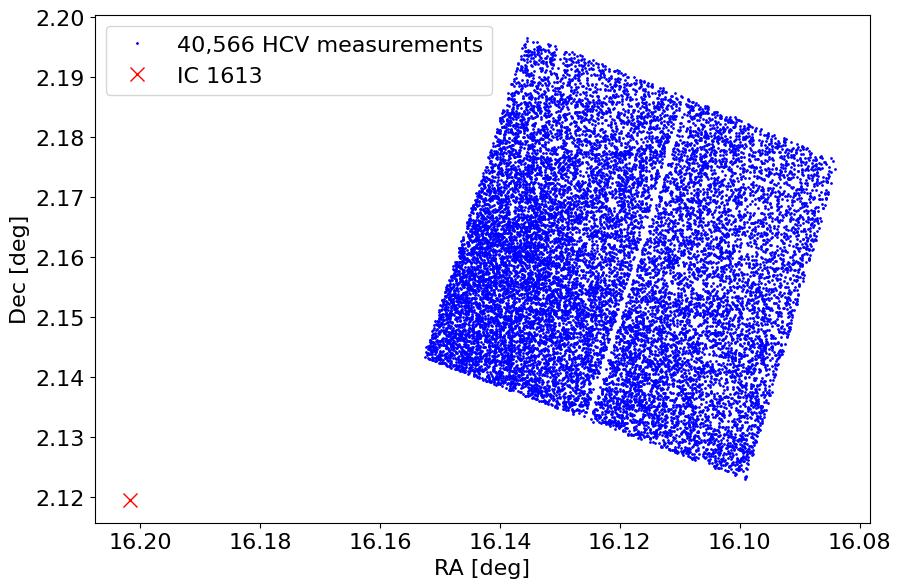

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot('RA', 'Dec', 'bo', markersize=1, label=f'{len(tab):,} HCV measurements', data=jtab)
ax.plot(ra_ic1613, dec_ic1613, 'rx', label=target, markersize=10)
ax.invert_xaxis()
ax.set(aspect='equal', xlabel='RA [deg]', ylabel='Dec [deg]')
ax.legend(loc='best')

### Plot HCV MAD variability index versus magnitude in F475W <a name="variability"></a>

The median absolute deviation variability index is used by the HCV to identify variables.  It measures the scatter among the multi-epoch measurements.  Some scatter is expected from noise (which increases for fainter objects).   Objects with MAD values that are high are likely to be variable.

This plots single-filter and multi-filter variable candidates (SFVC and MFVC) in different colors.  Note that variable objects with low F475W MAD values are variable in a different filter (typically F814W in this field).

This plot is similar to the upper panel of Figure 4 in [Bonanos et al. (2019, AAp)](https://www.aanda.org/component/article?access=doi&doi=10.1051/0004-6361/201936026).

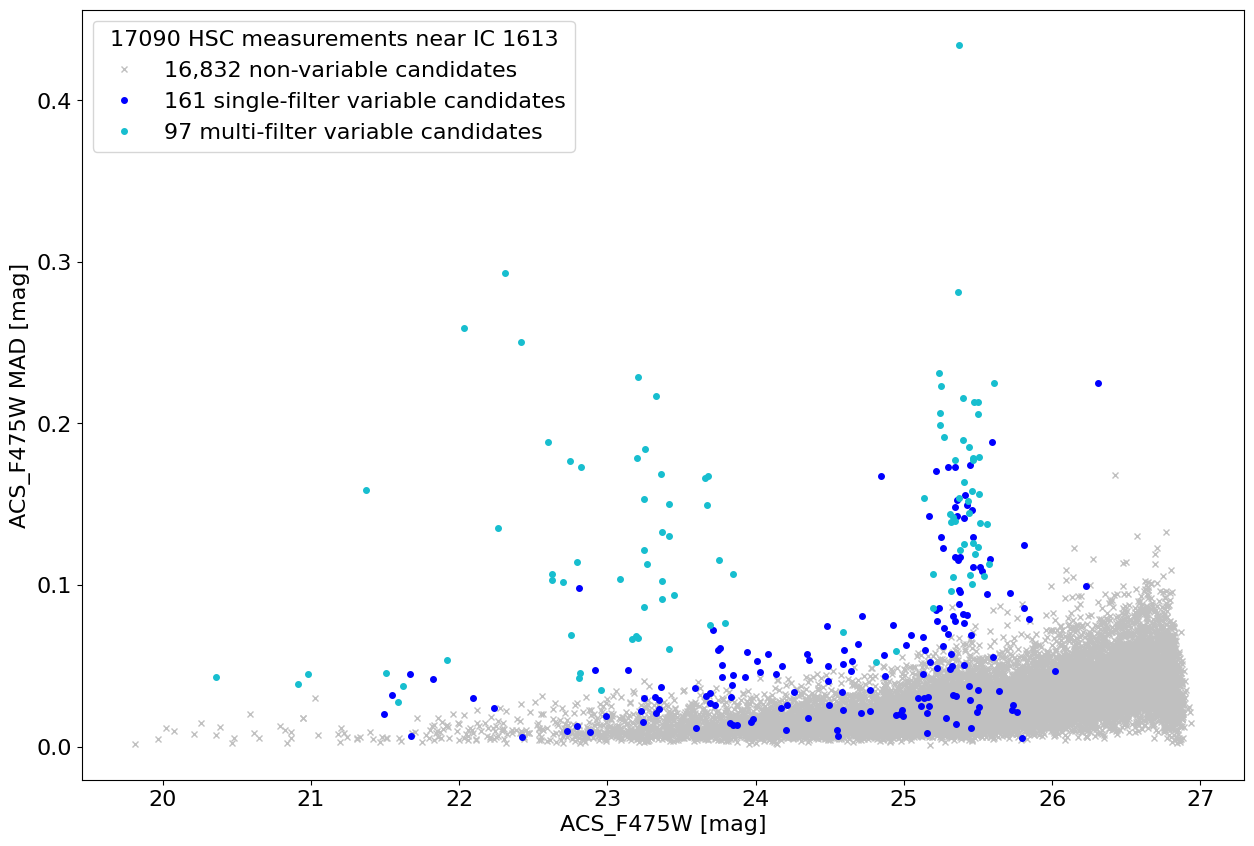

In [8]:
# define plot parameter lists
auto_class = np.unique(jtab['AutoClass'])
markers = ['x', 'o', 'o']
colors = ['silver', 'blue', 'tab:cyan']
labels = ['non-', 'single-filter ', 'multi-filter ']

fig, ax = plt.subplots(figsize=(15, 10))
for ac, marker, color, label in zip(auto_class, markers, colors, labels):
    data = jtab[jtab['AutoClass'] == ac]
    ax.plot('MeanCorrMag_f475', 'MAD_f475', marker, markersize=4, color=color,
            label=f'{len(data):,} {label}variable candidates', data=data)

ax.set(xlabel='ACS_F475W [mag]', ylabel='ACS_F475W MAD [mag]')
ax.legend(loc='best', title=f'{len(jtab)} HSC measurements near {target}')

### Plot variables in color-magnitude diagram <a name="cmd"></a>

Many of the candidate variables lie on the instability strip.

This plot is similar to the lower panel of Figure 4 in [Bonanos et al. (2019, AAp)](https://www.aanda.org/component/article?access=doi&doi=10.1051/0004-6361/201936026).

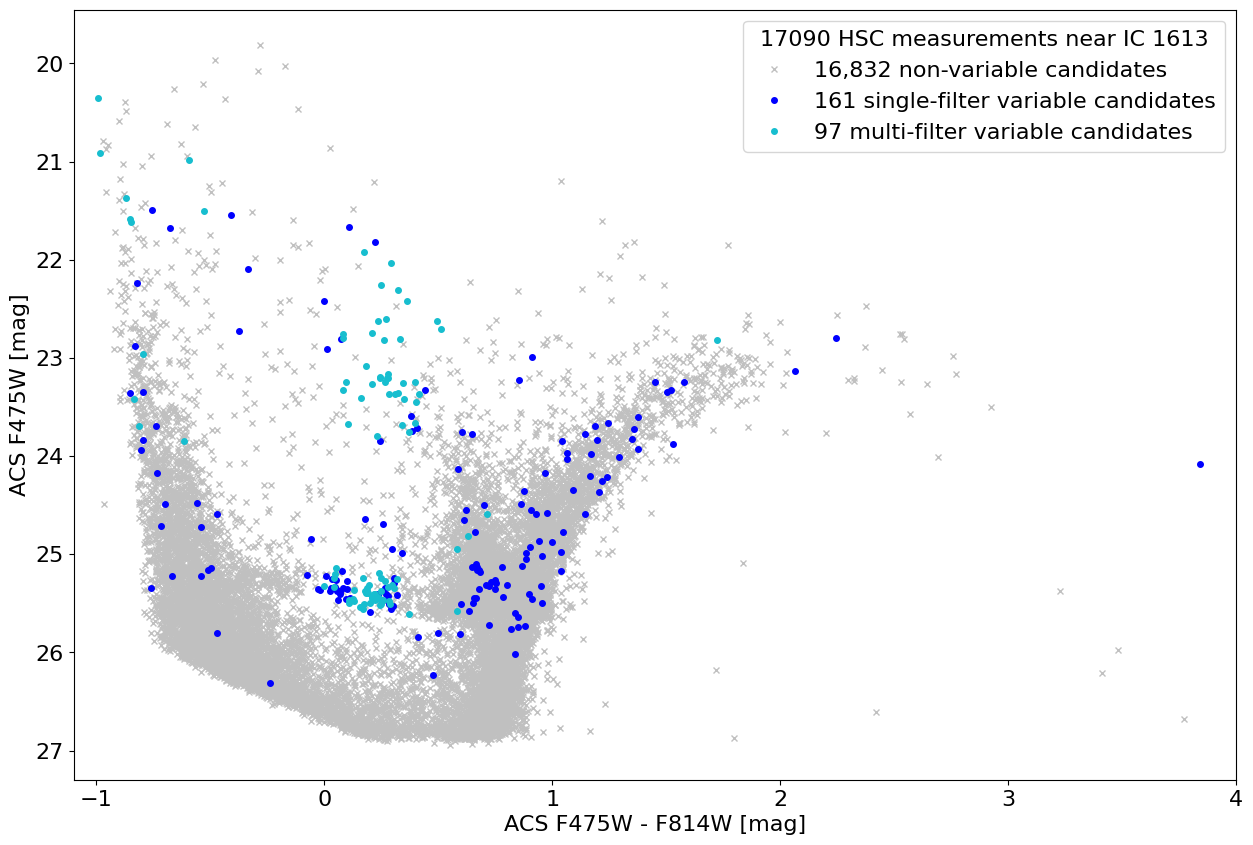

In [9]:
# add a new column to jtab
jtab['MCMf475-MCMf814'] = jtab['MeanCorrMag_f475'] - jtab['MeanCorrMag_f814']

fig, ax = plt.subplots(figsize=(15, 10))
# uses same plot parameters defined in the previous plot
for ac, marker, color, label in zip(auto_class, markers, colors, labels):
    data = jtab[jtab['AutoClass'] == ac]
    ax.plot('MCMf475-MCMf814', 'MeanCorrMag_f475', marker, markersize=4, color=color,
            label=f'{len(data):,} {label}variable candidates', data=data)
    
ax.invert_yaxis()
ax.set(xlim=(-1.1, 4), xlabel='ACS F475W - F814W [mag]', ylabel='ACS F475W [mag]')
ax.legend(loc='best', title=f'{len(jtab)} HSC measurements near {target}')

## Get a light curve for a nova in M87 <a name="m87"></a>

### Extract light curve for a given MatchID <a name="lightcurve"></a>

Note that the `MatchID` could be determined by positional searches, filtering the catalog, etc.  This object comes from the top left panel of Figure 9 in [Bonanos et al. (2019, AAp)](https://www.aanda.org/component/article?access=doi&doi=10.1051/0004-6361/201936026).

In [10]:
matchid = 1905457

t0 = time.time()

# get light curves for F606W and F814W
nova_606 = ascii.read(hcvsearch(table='hcv', MatchID=matchid, Filter='ACS_F606W'))
print(f"{(time.time()-t0):.1f} sec: retrieved {len(nova_606)} F606W measurements")

nova_814 = ascii.read(hcvsearch(table='hcv', MatchID=matchid, Filter='ACS_F814W'))
print(f"{(time.time()-t0):.1f} sec: retrieved {len(nova_814)} F814W measurements")

# get the object RA and Dec as well
nova_tab = ascii.read(hcvsearch(table='hcvsummary', MatchID=matchid, Filter='ACS_F814W'))
print(f"{(time.time()-t0):.1f} sec: retrieved object info")

nova_606

0.1 sec: retrieved 21 F606W measurements
0.2 sec: retrieved 22 F814W measurements


0.4 sec: retrieved object info


MatchID,Filter,MJD,ImageName,Mag,CorrMag,MagErr,CI,D
int64,str9,float64,str26,float64,float64,float64,float64,float64
1905457,ACS_F606W,53767.4197952871,hst_10543_29_acs_wfc_f606w,25.327,25.3267132802993,0.1305,0.840648114681244,13.499119758606
1905457,ACS_F606W,53768.4190663833,hst_10543_30_acs_wfc_f606w,23.9694,23.9676109802196,0.0394,1.04379630088806,11.9895544052124
1905457,ACS_F606W,53769.3576541713,hst_10543_31_acs_wfc_f606w,23.6005,23.6000842124737,0.0306,0.974166631698608,9.30478286743164
1905457,ACS_F606W,53771.1017052617,hst_10543_33_acs_wfc_f606w,23.6105,23.6157510517543,0.030300001,0.96657407283783,2.96933674812317
1905457,ACS_F606W,53772.8098534283,hst_10543_35_acs_wfc_f606w,23.621799,23.602993885395,0.0328,0.992037057876587,4.45478820800781
1905457,ACS_F606W,53774.4746564087,hst_10543_37_acs_wfc_f606w,24.015499,24.0123868023881,0.042599998,1.0246297121048,3.4874792098999
1905457,ACS_F606W,53775.2799112014,hst_10543_38_acs_wfc_f606w,23.9037,23.9077547341058,0.0381,0.985185205936432,3.49740219116211
1905457,ACS_F606W,53776.0893441574,hst_10543_39_acs_wfc_f606w,24.015499,24.0182108840315,0.0414,1.05314815044403,8.44466972351074
1905457,ACS_F606W,53776.9439852673,hst_10543_40_acs_wfc_f606w,24.065701,24.0743889490328,0.044599999,1.24157404899597,7.6749701499939


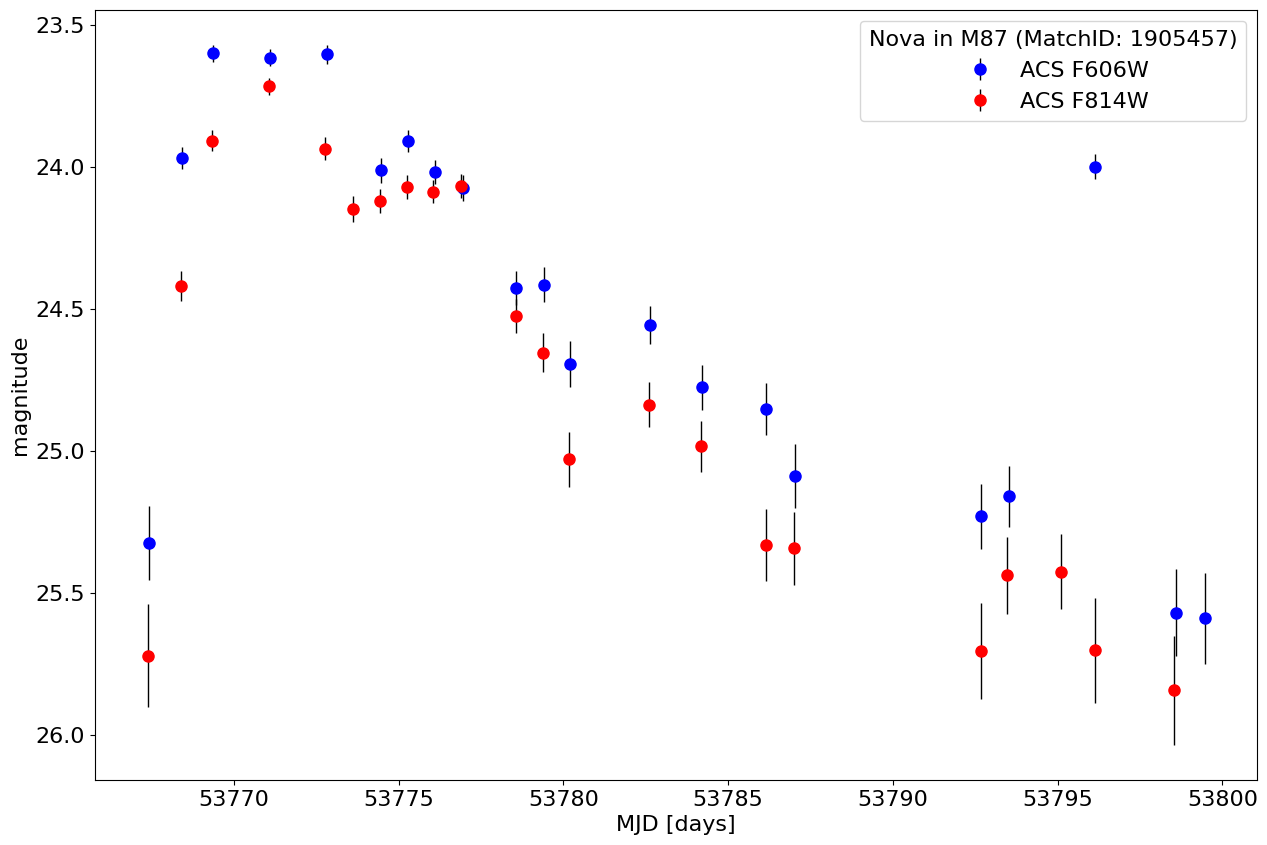

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.errorbar(x='MJD', y='CorrMag', yerr='MagErr', fmt='ob', ecolor='k', elinewidth=1, markersize=8, label='ACS F606W', data=nova_606)
ax.errorbar(x='MJD', y='CorrMag', yerr='MagErr', fmt='or', ecolor='k', elinewidth=1, markersize=8, label='ACS F814W', data=nova_814)

ax.invert_yaxis()
ax.set(xlabel='MJD [days]', ylabel='magnitude')
ax.legend(loc='best', title=f'Nova in M87 (MatchID: {matchid})')

### Get HLA image cutouts for the nova <a name="cutouts"></a>

The [Hubble Legacy Archive (HLA)](https://hla.stsci.edu) images were the source of the measurements in the HSC and HCV, and it can be useful to look at the images.  Examination of the images can be useful to identified cosmic-ray contamination and other possible image artifacts.  In this case, no issues are seen, so the light curve is reliable.

Note that the ACS F606W images of M87 have only a single exposure, so they do have cosmic ray contamination.  The accompanying F814W images have multiple exposures, allowing CRs to be removed.  In this case the F814W combined image is used to find objects, while the F606W exposure is used only for photometry.  That reduces the effects of F606W CRs on the catalog but it is still a good idea to confirm the quality of the images.

The `get_hla_cutout` function reads a single cutout image (as a JPEG grayscale image) and returns a PIL image object.  See the documentation on the [fitscut image cutout service](http://hla.stsci.edu/fitscutcgi_interface.html) for more information on the web service being used.

In [12]:
def get_hla_cutout(imagename, ra, dec, size=33, autoscale=99.5, asinh=True, zoom=1):
    """Get JPEG cutout for an image"""
    url = "https://hla.stsci.edu/cgi-bin/fitscut.cgi"
    r = requests.get(url, params=dict(ra=ra, dec=dec, size=size,
                                      format="jpeg", red=imagename, autoscale=autoscale, asinh=asinh, zoom=zoom))
    im = Image.open(BytesIO(r.content))
    return im

6.2 s: got 6 cutouts


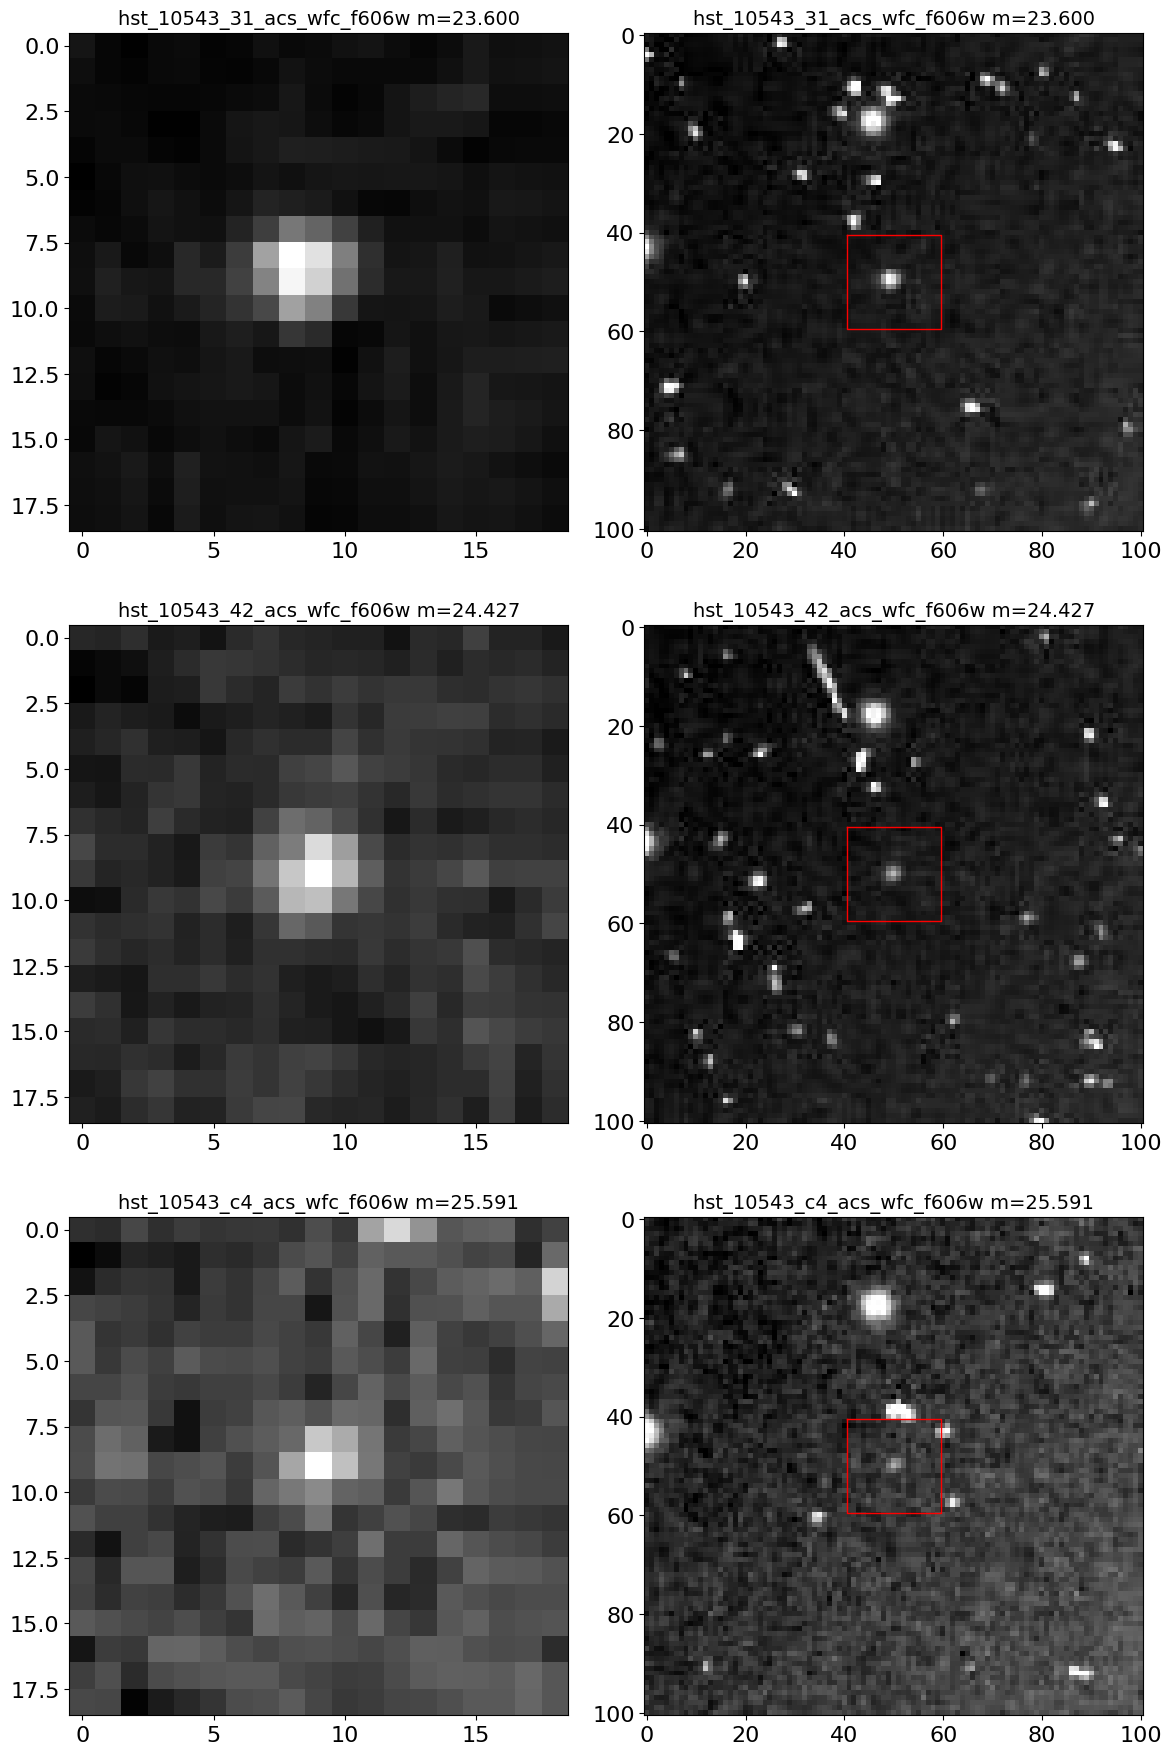

In [13]:
# sort images by magnitude from brightest to faintest
phot = nova_606
isort = np.argsort(phot['CorrMag'])
# select the brightest, median and faintest magnitudes
ind = [isort[0], isort[len(isort)//2], isort[-1]]

# we plot zoomed-in and zoomed-out views side-by-side for each selected image
nim = len(ind)*2
ncols = 2 # images per row
nrows = (nim+ncols-1)//ncols

imsize1 = 19
imsize2 = 101
mra = nova_tab['RA'][0]
mdec = nova_tab['Dec'][0]

# define figure and axes
fig, axes = plt.subplots(nrows, ncols, figsize=(12, (12/ncols)*nrows), tight_layout=True)

t0 = time.time()

# iterate through each set of two subplots in axes
for (ax1, ax2), k in zip(axes, ind):
    
    # get the images
    im1 = get_hla_cutout(phot['ImageName'][k], mra, mdec, size=imsize1)
    im2 = get_hla_cutout(phot['ImageName'][k], mra, mdec, size=imsize2)
    
    # plot left column   
    ax1.imshow(im1, origin="upper", cmap="gray")
    ax1.set_title(f"{phot['ImageName'][k]} m={phot['CorrMag'][k]:.3f}", fontsize=14)
    
    # plot right column
    ax2.imshow(im2, origin="upper", cmap="gray")
    xbox = np.array([-1, 1])*imsize1/2 + (imsize2-1)//2
    ax2.plot(xbox[[0, 1, 1, 0, 0]], xbox[[0, 0, 1, 1, 0]], 'r-', linewidth=1)
    ax2.set_title(f"{phot['ImageName'][k]} m={phot['CorrMag'][k]:.3f}", fontsize=14)    
    
print(f"{(time.time()-t0):.1f} s: got {nrows*ncols} cutouts")

## Compare the HCV automatic classification to expert validations <a name="expert"></a>

The HCV includes an automatic classification `AutoClass` for candidate variables as well as an expert validation for some fields that were selected for visual examination.  For this example, we select all the objects in the HCV that have expert classification information.

In [14]:
t0 = time.time()

# get data for objects with an expert validation
constraints = {"ExpertClass.gte": 1}
tab = ascii.read(hcvsearch(table="hcvsummary", **constraints))
print(f"Retrieved {len(tab)} rows in {(time.time()-t0):.1f} sec")

# clean up the output format
tab['MeanMag'].format = "{:.3f}"
tab['MeanCorrMag'].format = "{:.3f}"
tab['MAD'].format = "{:.4f}"
tab['Chi2'].format = "{:.4f}"
tab['RA'].format = "{:.6f}"
tab['Dec'].format = "{:.6f}"

# tab includes 1 row for each filter (so multiple rows for objects with multiple filters)
# get an array that has only one row per object
mval, uindex = np.unique(tab['MatchID'], return_index=True)
utab = tab[uindex]
print(f"{len(utab)} unique MatchIDs in table")

tab

Retrieved 31258 rows in 1.8 sec
13533 unique MatchIDs in table


MatchID,Filter,GroupID,SubGroupID,RA,Dec,AutoClass,ExpertClass,VarQualFlag,FilterDetFlag,NumLC,MeanMag,MeanCorrMag,MAD,Chi2
int64,str11,int64,int64,float64,float64,int64,int64,str5,int64,int64,float64,float64,float64,float64
875,ACS_F435W,1040153,-5,64.149673,-24.110353,2,2,AAAAA,0,13,24.166,24.166,0.0384,7.1169
875,ACS_F606W,1040153,-5,64.149673,-24.110353,2,2,AAAAC,0,9,22.836,22.835,0.0349,81.3676
875,ACS_F814W,1040153,-5,64.149673,-24.110353,2,2,AAAAA,0,23,22.156,22.156,0.0325,141.7171
875,WFC3_F105W,1040153,-5,64.149673,-24.110353,2,2,CAAAB,1,14,21.843,21.843,0.0503,223.4961
875,WFC3_F125W,1040153,-5,64.149673,-24.110353,2,2,CBCCA,1,6,21.813,21.814,0.0655,792.8662
875,WFC3_F140W,1040153,-5,64.149673,-24.110353,2,2,AAAAA,0,6,21.705,21.704,0.0205,127.6242
875,WFC3_F160W,1040153,-5,64.149673,-24.110353,2,2,BABAA,1,13,21.623,21.624,0.0322,112.8544
2006,WFPC2_F555W,521507,-5,268.112152,-17.684282,2,2,AAAAC,1,7,21.811,21.821,0.1545,85.2812
2006,WFPC2_F814W,521507,-5,268.112152,-17.684282,2,2,AAAAA,1,7,20.513,20.519,0.0988,105.2348


An `ExpertClass` value of 1 indicates that the object is confidently confirmed to be a variable; 2 means that the measurements do not have apparent problems and so the object is likely to be variable (usually the variability is too small to be obvious in the image); 4 means that the variability is likely to be the result of artifacts in the image (e.g., residual cosmic rays or diffraction spikes from nearby bright stars).

Compare the distributions for single-filter variable candidates (SFVC, `AutoClass`=1) and multi-filter variable candidates (MFVC, `AutoClass`=2).  The fraction of artifacts is lower in the MFVC sample.

In [15]:
sfcount = np.bincount(utab['ExpertClass'][utab['AutoClass'] == 1])
mfcount = np.bincount(utab['ExpertClass'][utab['AutoClass'] == 2])
sfrat = sfcount/sfcount.sum()
mfrat = mfcount/mfcount.sum()

print("Type Variable Likely Artifact Total")
print("SFVC {:8d} {:6d} {:8d} {:5d} counts".format(sfcount[1], sfcount[2], sfcount[4], sfcount.sum()))
print("MFVC {:8d} {:6d} {:8d} {:5d} counts".format(mfcount[1], mfcount[2], mfcount[4], mfcount.sum()))
print("SFVC {:8.3f} {:6.3f} {:8.3f} {:5.3f} fraction".format(sfrat[1], sfrat[2], sfrat[4], sfrat.sum()))
print("MFVC {:8.3f} {:6.3f} {:8.3f} {:5.3f} fraction".format(mfrat[1], mfrat[2], mfrat[4], mfrat.sum()))

Type Variable Likely Artifact Total
SFVC     3323   3055     1761  8139 counts
MFVC     2101   2442      851  5394 counts
SFVC    0.408  0.375    0.216 1.000 fraction
MFVC    0.390  0.453    0.158 1.000 fraction


### Plot the MAD variability index distribution with expert classifications <a name="mad_expert"></a>

Note that only the filters identified as variable (`FilterDetFlag` > 0) are included here.

This version of the plot shows the distributions for the various `ExpertClass` values along with, for comparison, the distribution for all objects in gray (which is identical in each panel).  Most objects are classified as confident or likely variables.  Objects with lower MAD values (indicating a lower amplitude of variability) are less likely to be identified as confident variables because low-level variability is more difficult to confirm via visual examination.

#### Data & Bins

In [16]:
w = np.where(tab['FilterDetFlag'] > 0)
mad = tab['MAD'][w]
e = tab['ExpertClass'][w]

xrange = [7.e-3, 2.0]
bins = xrange[0]*(xrange[1]/xrange[0])**np.linspace(0.0, 1.0, 50)

#### Plots

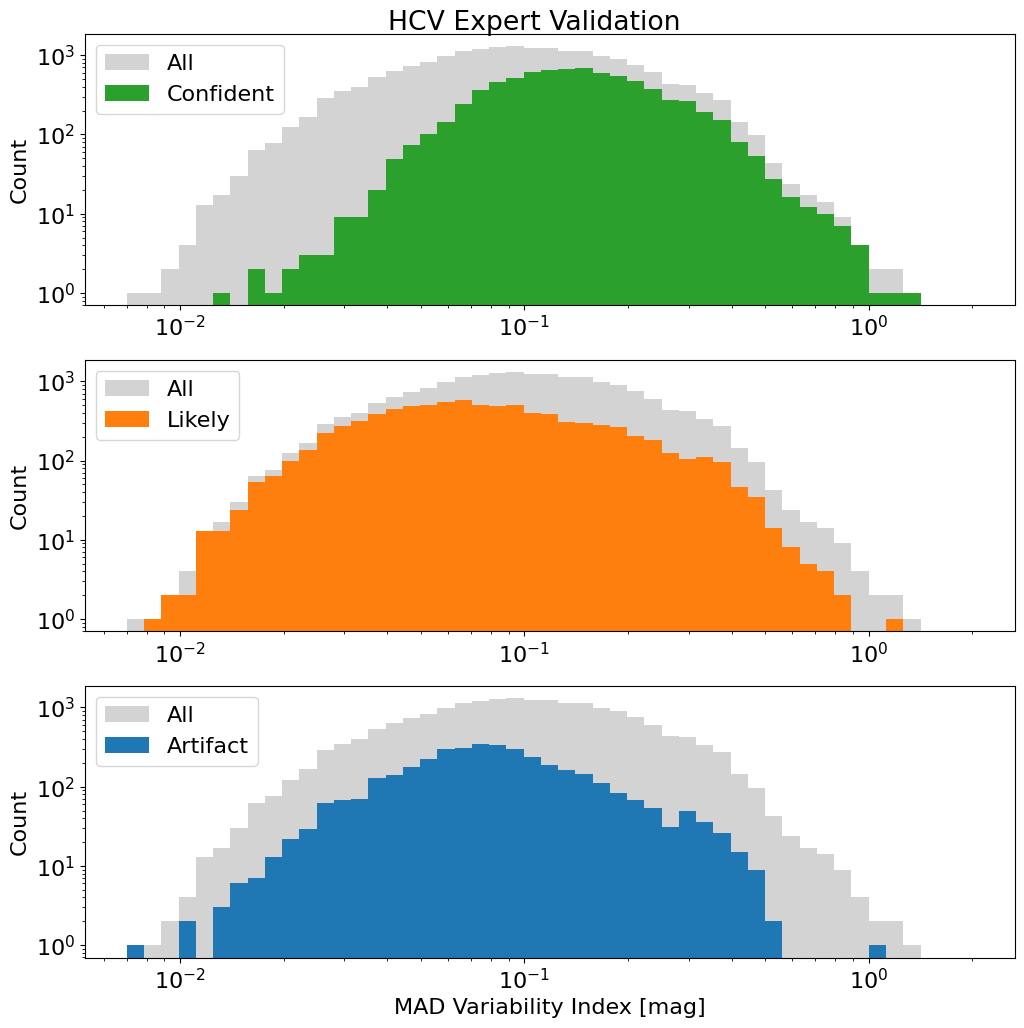

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

labels = ['Confident', 'Likely', 'Artifact']
colors = ['C2', 'C1', 'C0']

for ax, v, label, color in zip(axes, np.unique(e), labels, colors):
    ax.hist(mad, bins=bins, log=True, color='lightgray', label='All')
    ax.hist(mad[e == v], bins=bins, log=True, label=label, color=color)
    ax.set(xscale='log', ylabel='Count')
    ax.legend(loc='upper left')
    
fig.suptitle('HCV Expert Validation', y=0.9)
_ = axes[2].set_xlabel('MAD Variability Index [mag]')

The plot below shows the same distributions, but plotted as stacked histograms.  The top panel uses a linear scale on the y-axis and the bottom panel uses a log y scale.

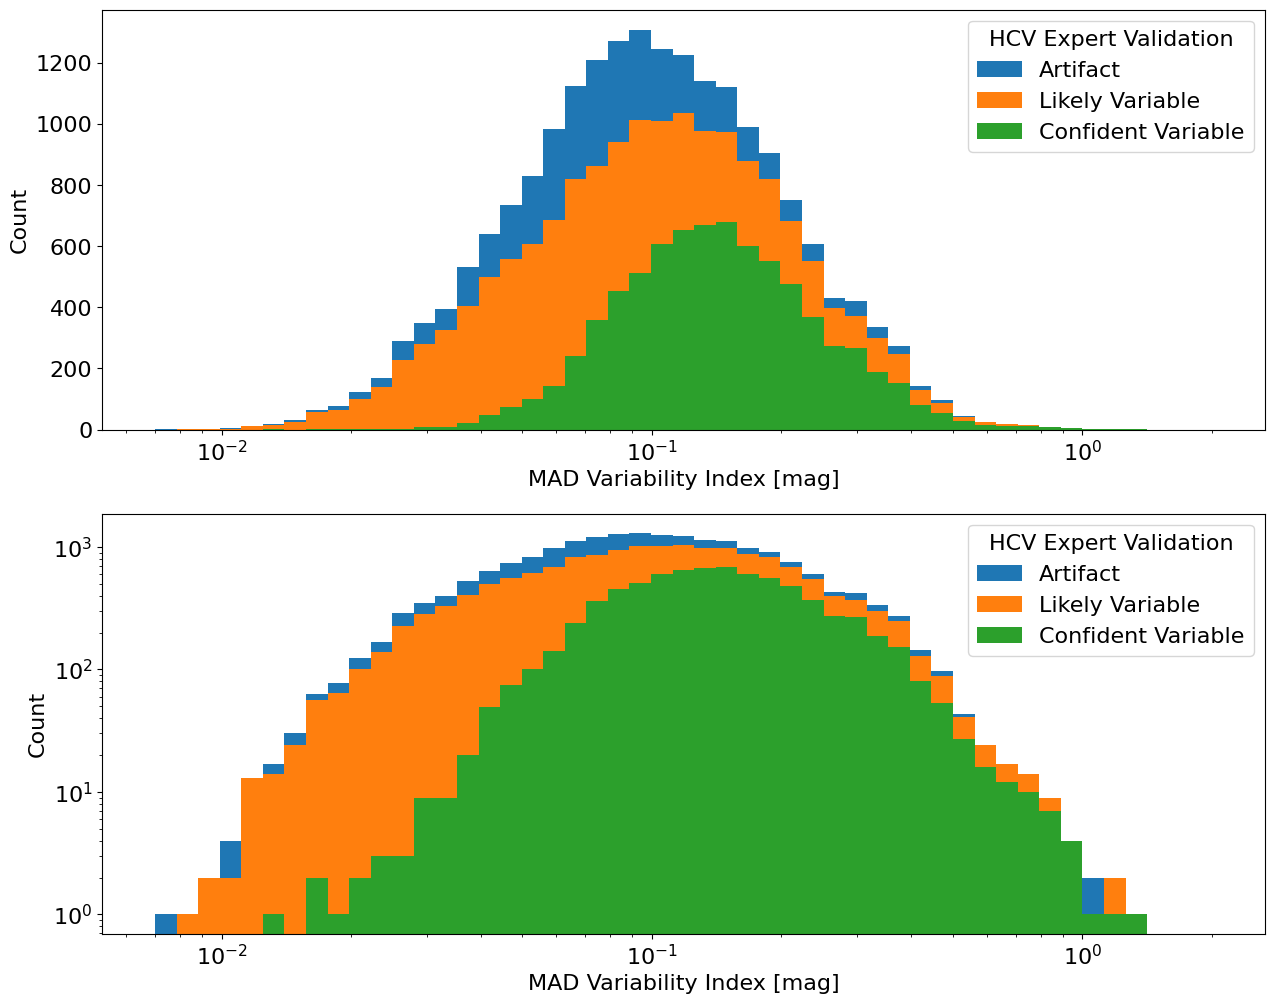

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

ylogs = [False, True]

for ax, ylog in zip(axes, ylogs):
    ax.hist(mad, bins=bins, log=ylog, label='Artifact')
    ax.hist(mad[e < 4], bins=bins, log=ylog, label='Likely Variable')
    ax.hist(mad[e == 1], bins=bins, log=ylog, label='Confident Variable')

    ax.set_xscale('log')
    ax.set_xlabel('MAD Variability Index [mag]')
    ax.set_ylabel('Count')
    ax.legend(loc='upper right', title='HCV Expert Validation')

### Plot the fraction of artifacts as a function of MAD variability index <a name="artifacts"></a>

This shows how the fraction of artifacts varies with the MAD value.  For larger MAD values the fraction decreases sharply, presumably because such large values are less likely to result from the usual artifacts.  Interestingly, the artifact fraction also declines for smaller MAD values (MAD < 0.1 mag).  Probably that happens because typical artifacts are more likely to produce strong signals than the weaker signals indicated by a low MAD value. 

In [19]:
w = np.where(tab['FilterDetFlag'] > 0)
mad = tab['MAD'][w]
e = tab['ExpertClass'][w]

xrange = [7.e-3, 2.0]
bins = xrange[0]*(xrange[1]/xrange[0])**np.linspace(0.0, 1.0, 30)

all_count, bin_edges = np.histogram(mad, bins=bins)
artifact_count, bin_edges = np.histogram(mad[e == 4], bins=bins)
wnz = np.where(all_count > 0)[0]
nnz = len(wnz)

artifact_count = artifact_count[wnz]
all_count = all_count[wnz]
xerr = np.empty((2, nnz), dtype=float)
xerr[0] = bin_edges[wnz]
xerr[1] = bin_edges[wnz+1]

# combine bins at edge into one big bin to improve the statistics there
iz = np.where(all_count.cumsum() > 10)[0][0]
if iz > 0:
    all_count[iz] += all_count[:iz].sum()
    artifact_count[iz] += artifact_count[:iz].sum()
    xerr[0, iz] = xerr[0, 0]
    all_count = all_count[iz:]
    artifact_count = artifact_count[iz:]
    xerr = xerr[:, iz:]
    
iz = np.where(all_count[::-1].cumsum() > 40)[0][0]
if iz > 0:
    all_count[-iz-1] += all_count[-iz:].sum()
    artifact_count[-iz-1] = artifact_count[-iz:].sum()
    xerr[1, -iz-1] = xerr[1, -1]
    all_count = all_count[:-iz]
    artifact_count = artifact_count[:-iz]
    xerr = xerr[:, :-iz]

x = np.sqrt(xerr[0]*xerr[1])
xerr[0] = x - xerr[0]
xerr[1] = xerr[1] - x

frac = artifact_count/all_count
# error on fraction using binomial distribution (approximate)
ferr = np.sqrt(frac*(1-frac)/all_count)

Create the plot

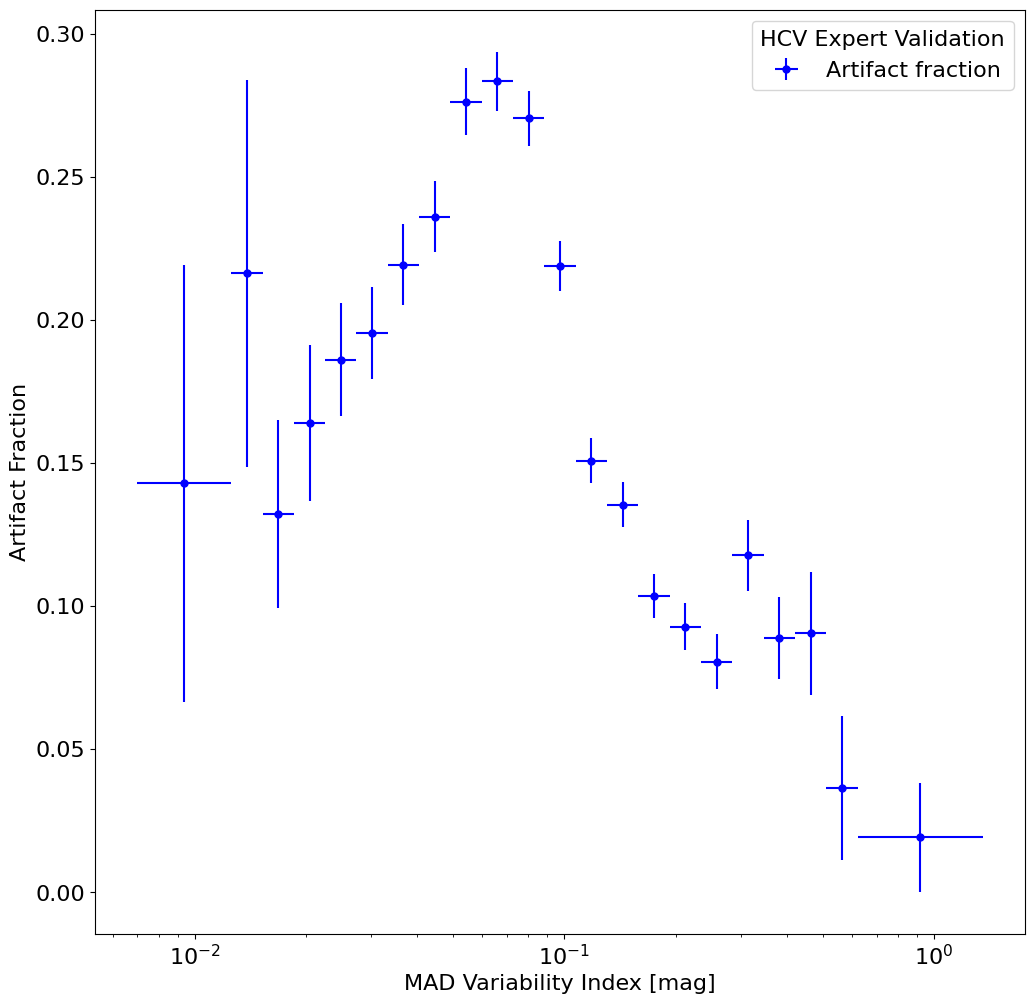

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.errorbar(x, frac, xerr=xerr, yerr=ferr, fmt='ob', markersize=5, label='Artifact fraction')
ax.set(xscale='log', xlabel='MAD Variability Index [mag]', ylabel='Artifact Fraction')
ax.legend(loc='upper right', title='HCV Expert Validation')

### Plot light curve for the most variable high quality candidate in the HCV <a name="most_variable"></a>

Select the candidate variable with the largest MAD value and `VarQualFlag` = 'AAAAA'.  To find the highest MAD value, we sort by MAD in descending order and select the first result.

In [21]:
constraints = {'VarQualFlag': 'AAAAA', 'sort_by': 'MAD.desc', 'pagesize': 1}

t0 = time.time()
tab = ascii.read(hcvsearch(table='hcvsummary', **constraints))
print("Completed in {:.1f} sec".format(time.time()-t0))

# clean up the output format
tab['MeanMag'].format = "{:.3f}"
tab['MeanCorrMag'].format = "{:.3f}"
tab['MAD'].format = "{:.4f}"
tab['Chi2'].format = "{:.4f}"
tab['RA'].format = "{:.6f}"
tab['Dec'].format = "{:.6f}"

print("MatchID {} has largest MAD value = {:.2f}".format(
    tab['MatchID'][0], tab['MAD'][0]))
tab

Completed in 1.4 sec
MatchID 5742711 has largest MAD value = 0.86


MatchID,Filter,GroupID,SubGroupID,RA,Dec,AutoClass,ExpertClass,VarQualFlag,FilterDetFlag,NumLC,MeanMag,MeanCorrMag,MAD,Chi2
int64,str9,int64,int64,float64,float64,int64,int64,str5,int64,int64,float64,float64,float64,float64
5742711,ACS_F814W,1045904,16,10.928601,41.164295,1,0,AAAAA,1,5,22.264,22.265,0.8581,6698.4430


Get the light curve.

In [22]:
matchid = tab['MatchID'][0]
mfilter = tab['Filter'][0]

t0 = time.time()
lc = ascii.read(hcvsearch(table="hcv", MatchID=matchid, Filter=mfilter))
print(f"{(time.time()-t0):.1f} sec: retrieved {len(lc)} {mfilter} measurements")

0.2 sec: retrieved 5 ACS_F814W measurements


Plot the light curve.

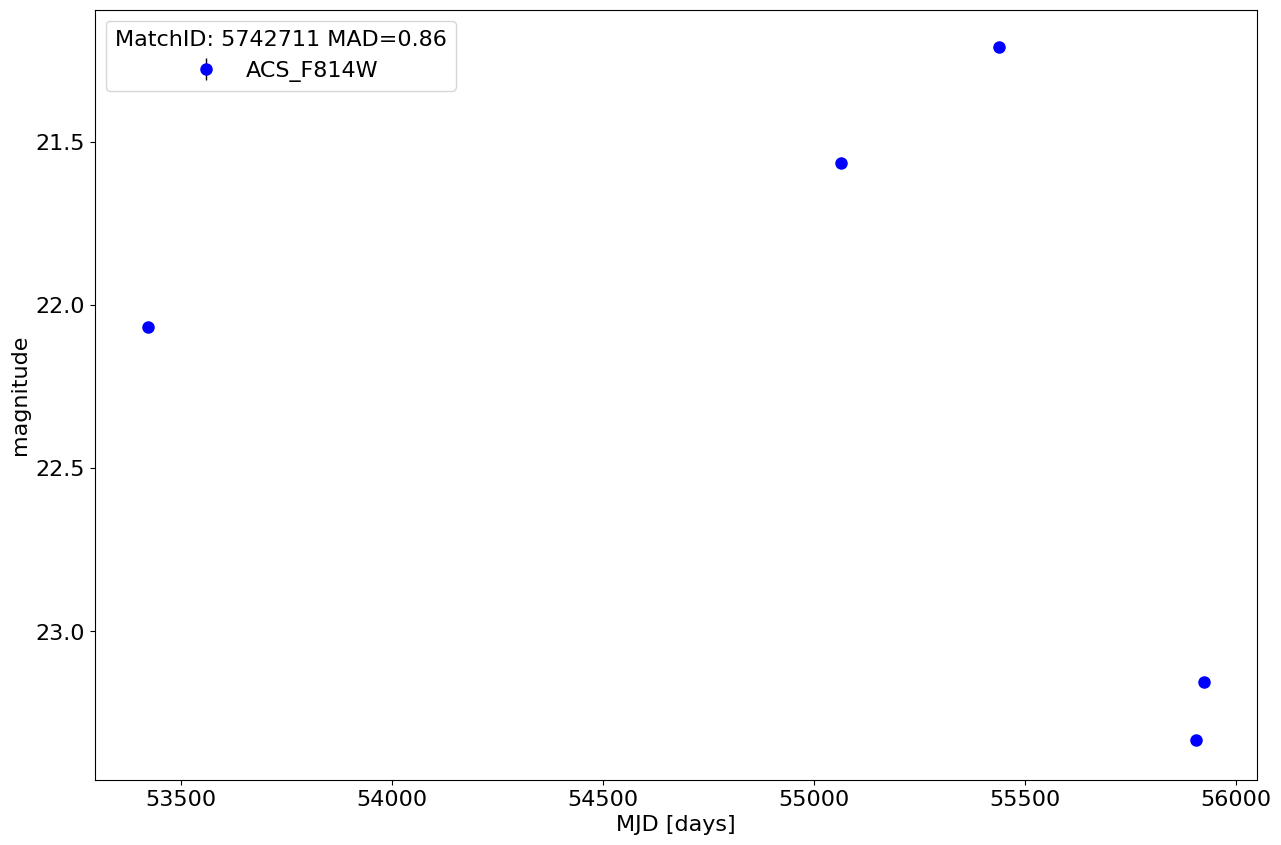

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.errorbar(x='MJD', y='CorrMag', yerr='MagErr', fmt='ob', ecolor='k', elinewidth=1, markersize=8, label=mfilter, data=lc)

ax.invert_yaxis()
ax.set(xlabel='MJD [days]', ylabel='magnitude')
ax.legend(loc='best', title=f"MatchID: {matchid} MAD={tab['MAD'][0]:.2f}")

Extract cutout images for the entire light curve (since it does not have many points).

2.3 s: finished 1 of 5 epochs


4.3 s: finished 2 of 5 epochs


6.2 s: finished 3 of 5 epochs


8.2 s: finished 4 of 5 epochs


10.1 s: finished 5 of 5 epochs
10.1 s: got 10 cutouts


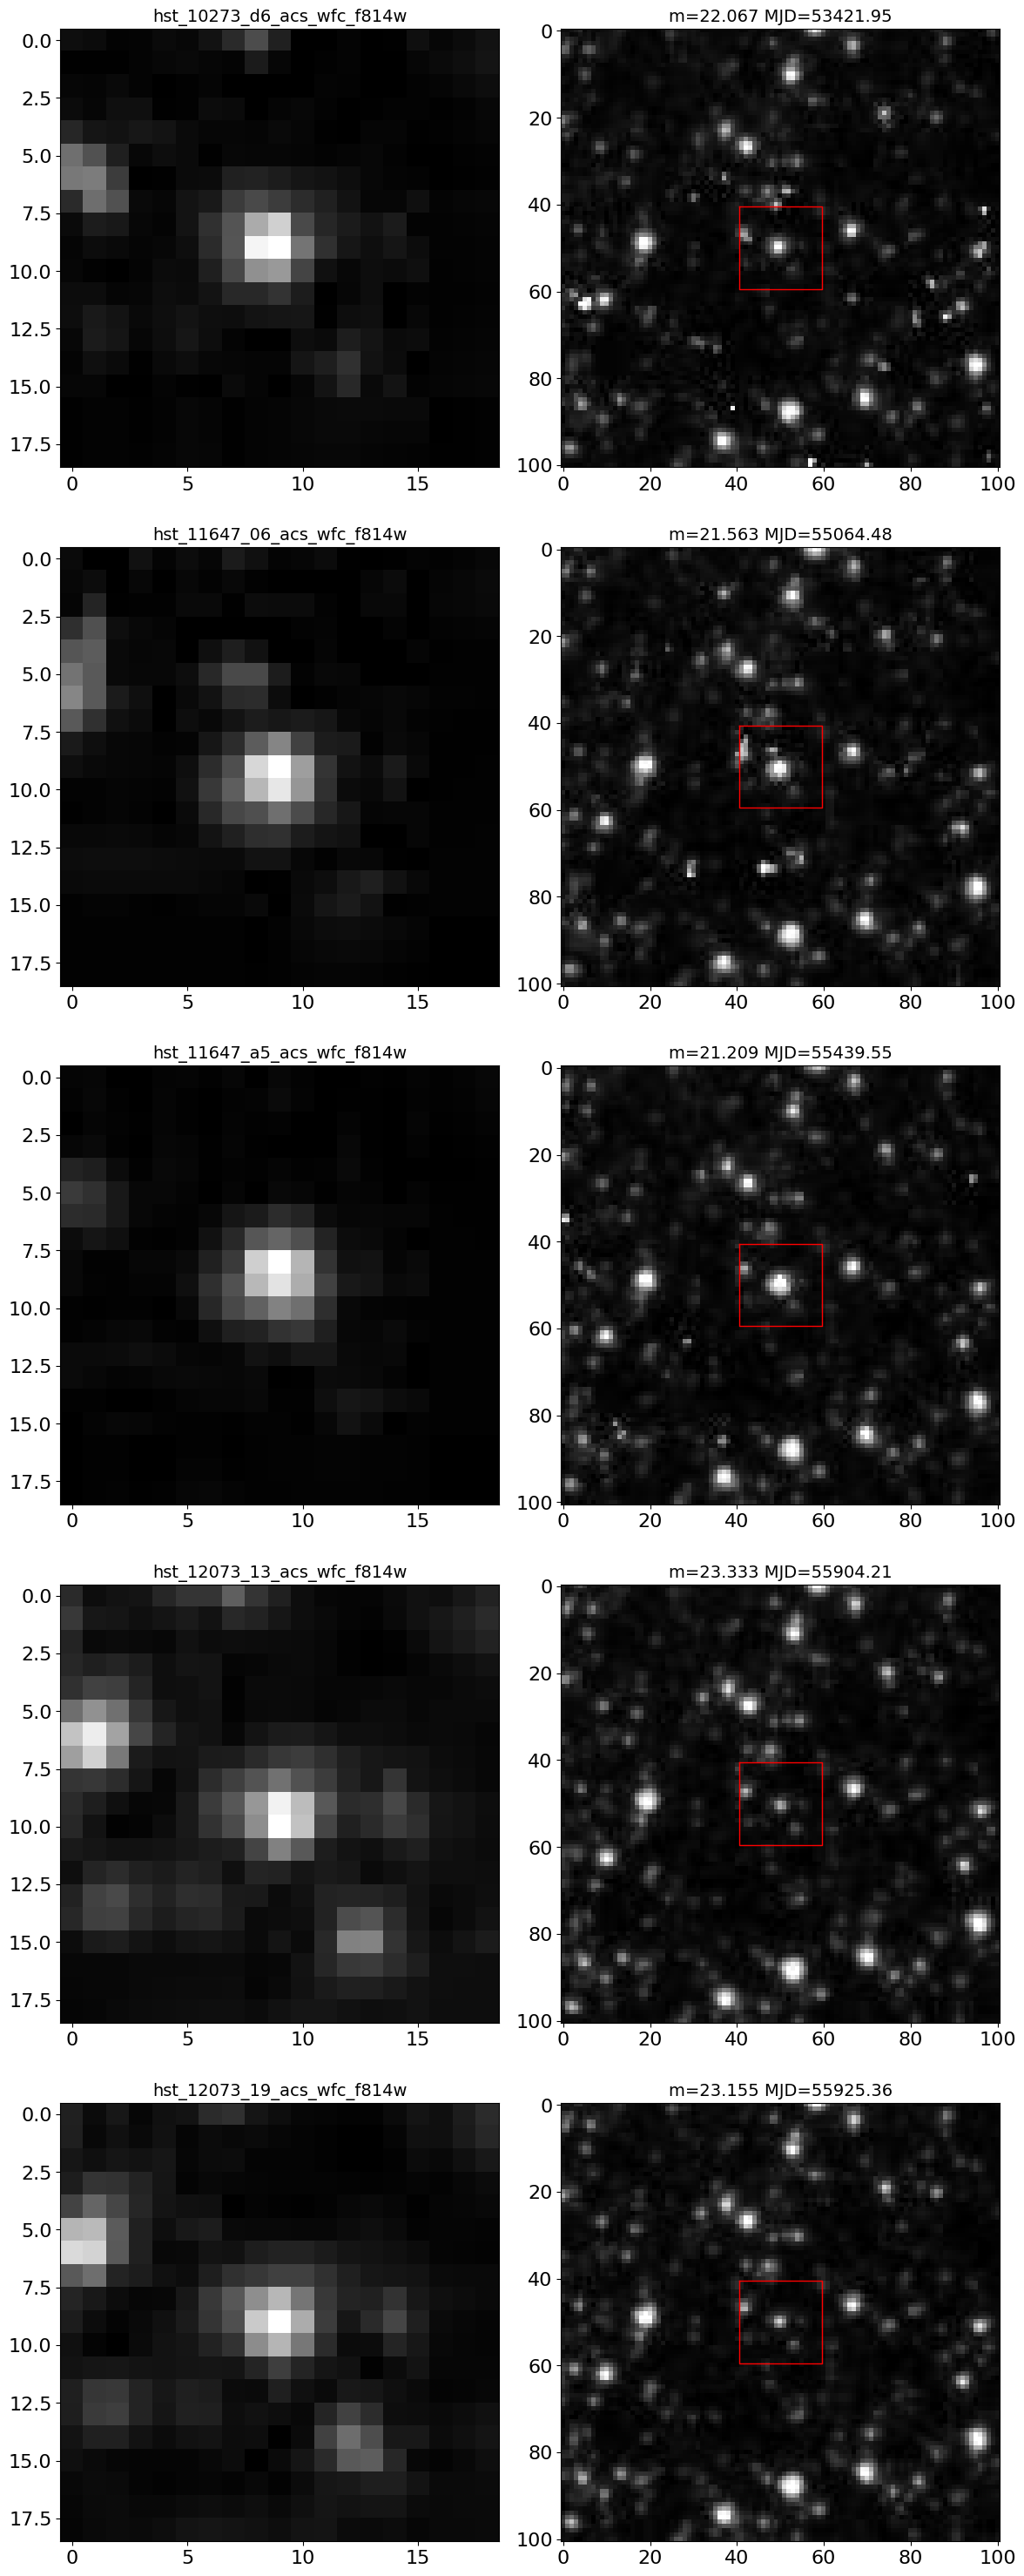

In [24]:
# sort images in MJD order
ind = np.argsort(lc['MJD'])

# we plot zoomed-in and zoomed-out views side-by-side for each selected image
nim = len(ind)*2
ncols = 2 # images per row
nrows = (nim+ncols-1)//ncols

imsize1 = 19
imsize2 = 101
mra = tab['RA'][0]
mdec = tab['Dec'][0]

# define figure and axes
fig, axes = plt.subplots(nrows, ncols, figsize=(12, (12/ncols)*nrows), tight_layout=True)

t0 = time.time()

# iterate through each set of two subplots in axes
for i, ((ax1, ax2), k) in enumerate(zip(axes, ind), 1):
    
    # get the images
    im1 = get_hla_cutout(lc['ImageName'][k], mra, mdec, size=imsize1)
    im2 = get_hla_cutout(lc['ImageName'][k], mra, mdec, size=imsize2)
    
    # plot left column    
    ax1.imshow(im1, origin="upper", cmap="gray")
    ax1.set_title(lc['ImageName'][k], fontsize=14)
    
    # plot right column
    ax2.imshow(im2, origin="upper", cmap="gray")
    xbox = np.array([-1, 1])*imsize1/2 + (imsize2-1)//2
    ax2.plot(xbox[[0, 1, 1, 0, 0]], xbox[[0, 0, 1, 1, 0]], 'r-', linewidth=1)
    ax2.set_title(f"m={lc['CorrMag'][k]:.3f} MJD={lc['MJD'][k]:.2f}", fontsize=14)
    
    print(f"{(time.time()-t0):.1f} s: finished {i} of {len(ind)} epochs")

print(f"{(time.time()-t0):.1f} s: got {nrows*ncols} cutouts")